In [213]:
import sys
if sys.platform == 'win32':
    sys.path.append(r"C:\Users\vl385\Documents\casadi-windows-py37-v3.5.1") 
else:
    sys.path.append(r"casadiinstalldir")
import casadi as ca

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import numpy.linalg as LA
from scipy.integrate import odeint
# from cfm import *
# import tensorflow as tf
# from tensorflow import keras
import tikzplotlib
import copy
from timeit import default_timer as timer
import sympy as sp

## Pre computation

In [215]:
p1, v1, a1 = sp.symbols('p1 v1 a1')
p2, v2 = sp.symbols('p2 v2')
w1, w2, w3 = sp.symbols('w1 w2 w3')
v_min, v_max = sp.symbols('v_min, v_max')
a_min, a_max = sp.symbols('a_min, a_max')
alpha, rho = sp.symbols('alpha, rho')
tau = sp.symbols('tau')

In [216]:
X = sp.Matrix([[p1],[v1]])
U = sp.Matrix([[a1]])

In [217]:
V = w2*(v1-v_max)**2 - w3*sp.log(p1**2+p2**2-2*alpha*p1*p2-rho**2)

In [218]:
V_x = sp.diff(V, X)
V_x = sp.simplify(V_x)

In [219]:
V_x

Matrix([
[-2*w3*(alpha*p2 - p1)/(2*alpha*p1*p2 - p1**2 - p2**2 + rho**2)],
[                                             2*w2*(v1 - v_max)]])

In [220]:
V_xx = sp.Matrix([sp.diff(V_x[0], X).T, sp.diff(V_x[1], X).T]).T
V_xx = sp.simplify(V_xx)

In [221]:
V_xx

Matrix([
[2*w3*(2*alpha*p1*p2 - p1**2 - p2**2 + rho**2 + 2*(alpha*p2 - p1)**2)/(2*alpha*p1*p2 - p1**2 - p2**2 + rho**2)**2,    0],
[                                                                                                               0, 2*w2]])

In [222]:
L_k = w1*a1**2

In [223]:
V_u = sp.diff(L_k, U)
V_u = sp.simplify(V_u)
V_u

Matrix([[2*a1*w1]])

In [224]:
V_uu = sp.Matrix([sp.diff(V_u[0], U).T]).T
V_uu = sp.simplify(V_uu)
V_uu

Matrix([[2*w1]])

# Simulation 

## Some functions

In [225]:
def in_control_zone(p, control_zone):
    if p >= control_zone[0] and p <= control_zone[1]:
        return True
    else:
        return False

def distance(p1, p2, angle):
    if p2 <= 0:
        dist = np.sqrt(p1**2 + p2**2 - 2*np.cos(angle)*p1*p2)
    elif p2 > 0:
        dist = np.abs(p1-p2)
    return dist

## Main classes


In [226]:
class HDV:
    lc = 3.0 # car length
    
    # velocity and input bounds      
    v_min = 0.0; v_max = 30.0
    u_min = -10.0; u_max = 5.0
    
    def __init__(self, x0, T = 0.1):
        self.st = x0
        self.input = 0.0
        self.T = T

        self.X_hist = np.empty([2,0], dtype=np.ndarray)
        self.U_hist = np.empty([0], dtype=float)
        self.X_hist = np.hstack([self.X_hist, x0.reshape([-1,1])])
        
    def set_cfm(self, model):
        self.model = model
        
    def update_measurement(self, st_h):
        self.p_h = st_h[0]; self.v_h = st_h[1]; self.u_h = st_h[2]
        
    def get_input(self):
        p = self.st[0]; v = self.st[1]
        delta_p = self.p_h - p - self.lc
        delta_v = self.v_h - v
        u = self.model.action(p, v, self.p_h, self.v_h, self.u_h)
            
#         u = max(self.u_min, min(self.u_max, u))
        if v + self.T*u > self.v_max:
            u = (self.v_max-v)/self.T
        elif v + self.T*u < self.v_min:
            u = (self.v_min-v)/self.T
        return u
    
    def car_model(self, z, t, u):
        p = z[0]; v = z[1]
        
        dz = np.zeros(2)
        dz[0] = v
        dz[1] = u
        return dz
        
    def run(self, u):
        tspan = np.linspace(0, self.T, 3)
        y = odeint(self.car_model, self.st, tspan, args=(u,)) 
        self.st = y[-1,] 
        self.input = u
        self.X_hist = np.hstack([self.X_hist, self.st.reshape([-1,1])])
        self.U_hist = np.hstack([self.U_hist, self.input])  
        
    def run_v(self, v):
        v = max(self.v_min, min(self.v_max, v))
        if (v - self.st[1])/self.T < self.u_min:
            v = self.st[1] + self.T*self.u_min
        elif (v - self.st[1])/self.T > self.u_max:
            v = self.st[1] + self.T*self.u_max
        y = self.st[0] + self.T*v
        self.st = np.array([y, v])
        self.X_hist = np.hstack([self.X_hist, self.st.reshape([-1,1])])
        self.U_hist = np.hstack([self.U_hist, self.input])     

In [227]:
class CAV:
    lc = 3.0 # car length
    
    # velocity and input bounds      
    v_min = 0.0; v_max = 30.0
    u_min = -10.0; u_max = 5.0
    
    def __init__(self, x0, T = 0.1):
        self.st = x0
        self.input = 0.0
        self.T = T
        self.X_hist = np.empty([2,0], dtype=np.ndarray)
        self.U_hist = np.empty([0], dtype=float)
        self.X_hist = np.hstack([self.X_hist, x0.reshape([-1,1])])
        
    def car_model(self, z, t, u):
        v = z[1]

        dz = np.zeros(2)
        dz[0] = v
        dz[1] = u
        return dz
        
    def run(self, u):
        u = max(self.u_min, min(self.u_max, u))
        v = self.st[1]
        if v + self.T*u > self.v_max:
            u = (self.v_max-v)/self.T
        elif v + self.T*u < self.v_min:
            u = (self.v_min-v)/self.T
        
        tspan = np.linspace(0, self.T, 3)
        y = odeint(self.car_model, self.st, tspan, args=(u,)) 
        self.st = y[-1,] 
        self.input = u
        self.X_hist = np.hstack([self.X_hist, self.st.reshape([-1,1])])
        self.U_hist = np.hstack([self.U_hist, self.input])        
        
    def run_v(self, v):
        v = max(self.v_min, min(self.v_max, v))
        if (v - self.st[1])/self.T < self.u_min:
            v = self.st[1] + self.T*self.u_min
        elif (v - self.st[1])/self.T > self.u_max:
            v = self.st[1] + self.T*self.u_max
        y = self.st[0] + self.T*v
        self.st = np.array([y, v])
        self.X_hist = np.hstack([self.X_hist, self.st.reshape([-1,1])])
        self.U_hist = np.hstack([self.U_hist, self.input])            

In [378]:
class CILQR:
    # velocity and input bounds      
    v_min = 0.0; v_max = 30.0
    u_min = -10.0; u_max = 5.0
    H_max = 20
    
    def __init__(self, H = 10, T = 0.1, gamma = 1e-4, lamda = 0.5, mu = 2.0):
        self.H = H; self.T = T
        self.gamma = gamma; self.alpha = alpha; self.mu = mu
        
    def set_state(self, states, HDV_st):
        self.st = states
        self.HDV_st = HDV_st
        
    def set_road_info(self, r, ang):
        self.r = r; self.alpha = np.cos(ang)
        
    def set_weight(self, W):
        self.W = W
        
    def update_horizon(self):
        H_1_f = int(-(self.st[0]/self.st[1])/self.T) if self.st[1] > 0 else np.inf
        H_2_f = int(-(self.HDV_st[0]/self.HDV_st[1])/self.T) if self.HDV_st[1] > 0 else np.inf

        self.H = max(1, min(H_1_f, H_2_f, self.H_max)) 
        
    def initialize(self):
        self.f_x = np.array([[1, self.T], [0, 1]])
        self.f_u = np.array([[self.T**2/2], [0.1]])
    
    def set_nominal(self, nom_inputs = None):
        self.nom_inputs = nom_inputs

        self.nom_states = np.zeros([2, self.H+1])
        self.nom_states[:,0] = self.st
        for k in range(self.H):
            x_k = self.nom_states[:,k]; u_k = self.nom_inputs[:,k]
            self.nom_states[:,k+1] = x_k \
                    + np.array([self.T*x_k[1], 0.5*self.T**2*u_k[0]])
            
    def predict_HDV(self):
        self.HDV_pred = np.zeros([2, self.H+1])
        self.HDV_pred[:,0] = self.HDV_st
        for k in range(self.H):
            x_k = self.HDV_pred[:,k]; u_k = 0.0
            self.HDV_pred[:,k+1] = x_k \
                    + np.array([self.T*x_k[1], 0.5*self.T**2*u_k])
            
    def backward(self):
        x_k = self.nom_states[:,-1]; x2_k = self.HDV_pred[:,-1]
        X = x_k.tolist() + x2_k.tolist()
        P1 = [self.W[1], self.W[2], self.alpha, self.r, self.v_max]
        P2 = self.W[0]
        V_k_x = self.num_V_x(X, P1); V_k_xx = self.num_V_xx(X, P1)
        
        self.q_k = np.empty(self.H, dtype=np.ndarray)
        self.Q_k = np.empty(self.H, dtype=np.ndarray)
        
        for k in range(self.H):
            x_k = self.nom_states[:,-2-k]; x2_k = self.HDV_pred[:,-2-k]
            u_k = self.nom_inputs[0,-1-k]
            X = x_k.tolist() + x2_k.tolist(); U = u_k

            L_k_x = self.num_V_x(X, P1); L_k_xx = self.num_V_xx(X, P1)
            L_k_u = self.num_V_u(U, P2); L_k_uu = self.num_V_uu(U, P2)
            
            P_k_x = L_k_x + np.dot(self.f_x.T, V_k_x)
            P_k_u = L_k_u + np.dot(self.f_u.T, V_k_x)
            P_k_xx = L_k_xx + LA.multi_dot([self.f_x.T, V_k_xx, self.f_x])
            P_k_uu = L_k_uu + LA.multi_dot([self.f_u.T, V_k_xx, self.f_u])
            P_k_ux = LA.multi_dot([self.f_u.T, V_k_xx, self.f_x])
            
            P_k_uu_inv = LA.inv(P_k_uu) 
            q_k = -np.dot(P_k_uu_inv, P_k_u); self.q_k[-1-k] = q_k
            Q_k = -np.dot(P_k_uu_inv, P_k_ux); self.Q_k[-1-k] = Q_k
            V_k_x = P_k_x - LA.multi_dot([P_k_u.T, P_k_uu_inv, P_k_ux]).T
            V_k_xx = P_k_xx - LA.multi_dot([P_k_ux.T, P_k_uu_inv, P_k_ux]) 

    def forward(self):
        nom_states = copy.deepcopy(self.nom_states)
        nom_inputs = copy.deepcopy(self.nom_inputs)
        for k in range(self.H):
            delta_x = self.nom_states[:,k] - nom_states[:,k]
            self.nom_inputs[:,k] += self.q_k[k].ravel() + np.dot(self.Q_k[k], delta_x)
            x_k = self.nom_states[:,k]; u_k = self.nom_inputs[:,k]
            self.nom_states[:,k+1] = x_k + \
                    np.array([self.T*x_k[1], 0.5*self.T**2*u_k[0]])
        residual = LA.norm(self.nom_inputs - nom_inputs) 
        return residual
        
    def CILQR(self, max_iters = 100, thres = 1e-3):
        self.predict_HDV()
        print(self.H)
        for i in range(max_iters):
#             self.gamma *= self.mu
            self.backward()
            res = self.forward()
#             print(i, res)
            if res <= thres:
                break
        
    def num_V_x(self, X, P):
        p1, v1, p2, v2 = X
        w2, w3, alpha, rho, v_max = P
        V = np.zeros([2,1])
        dem = (2*alpha*p1*p2-p1**2-p2**2+rho**2)
        V[0,0] = 2*w3*(-alpha*p2+p1)/dem
        V[1,0] = 2*w2*(v1-v_max)

        return V

    def num_V_xx(self, X, P):
        p1, v1, p2, v2 = X
        w2, w3, alpha, rho, v_max = P
        V = np.zeros([2,2])
        dem = (2*alpha*p1*p2-p1**2-p2**2+rho**2)**2
        V[0,0] = 2*w3*(2*alpha*p1*p2-p1**2-p2**2+rho**2+2*(alpha*p2-p1)**2)/dem
        V[1,1] = 2*w2
        return V

    def num_V_u(self, U, P):
        a1 = U
        w1 = P
        V = np.zeros([1,1])
        V[0,0] = 2*w1*a1
        return V

    def num_V_uu(self, U, P):
        a1 = U
        w1 = P
        V = np.zeros([1,1])
        V[0,0] = 2*w1
        return V


## Main program

In [386]:
np.random.seed(28)
T = 0.1; H = 20
HDV_ego = True
control_zone = np.array([-120, 0])

cars = []
cars.append(CAV(np.array([-150.0, 25.0])))
cars.append(HDV(np.array([-150.0, 25.0])))

control = CILQR(H, T)  
W = np.array([1.,1.,1e3])
control.set_weight(W)
r = 10; ang = np.pi/6; v_ref = 25
control.set_road_info(r, ang)
control.initialize()
control.set_state(cars[0].st, cars[1].st)
control.set_nominal(nom_inputs = np.zeros([1, H]))

start = timer()
control.CILQR()
end = timer()
print((end-start)*1e3)
# control.set_nominal(control.nom_inputs)

L = 200 # number of simulation steps

20
21.119982993695885


In [387]:
enter_t = 0; exit_t = L
for t in range(L):
    print("Time step %s" %t)
    cars[1].update_measurement(np.hstack([cars[0].st, cars[0].input]))

    # Now let's run
    if in_control_zone(cars[0].st[0], control_zone) and in_control_zone(cars[1].st[0], control_zone):
        if enter_t == 0: enter_t = t
        start = timer()
        control.CILQR()
        end = timer()
        print((end-start)*1e3)
        cars[0].run(control.nom_inputs[0,0])
        if HDV_ego:
            cars[1].run(min(cars[1].u_max, (cars[1].v_max-cars[1].st[1])/T))   
        else:
            cars[1].run(max(cars[1].u_min, (cars[1].v_min-cars[1].st[1])/T))   

        # Update measurement
        control.set_state(cars[0].st, cars[1].st)
        control.update_horizon()
        control.set_nominal(np.hstack([control.nom_inputs[:,1:control.H], np.zeros([1,1])]))

    else:
        cars[0].run_v(v_ref)
        cars[1].run_v(v_ref)   
        # Update measurement
        control.set_state(cars[0].st, cars[1].st)


    if not in_control_zone(cars[0].st[0], control_zone) and not in_control_zone(cars[1].st[0], control_zone):
        if exit_t == L and enter_t != 0: exit_t = t+1
    


Time step 0
Time step 1
Time step 2
Time step 3
Time step 4
Time step 5
Time step 6
Time step 7
Time step 8
Time step 9
Time step 10
Time step 11
Time step 12
20
26.339709002058953
Time step 13
20
18.269369000336155
Time step 14
20
15.594091993989423
Time step 15
20
14.696019003167748
Time step 16
20
14.763384009711444
Time step 17
20
14.177974997437559
Time step 18
20
14.127575006568804
Time step 19
20
14.678970008390024
Time step 20
20
16.07822898949962
Time step 21
20
15.650542991352268
Time step 22
20
16.000467992853373
Time step 23
20
17.672675996436737
Time step 24
20
21.683137005311437
Time step 25
20
21.138935000635684
Time step 26
20
19.078828001511283
Time step 27
20
17.879920997074805
Time step 28
20
17.911218994413503
Time step 29
20
18.298822003998794
Time step 30
20
18.26648600399494
Time step 31
20
17.939830999239348
Time step 32
20
17.47524499660358
Time step 33
19
12.231215005158447
Time step 34
18
12.689916009549052
Time step 35
17
13.836005993653089
Time step 36
16
1

In [388]:
L = cars[0].X_hist[0,:].shape[0]

X_hist = np.zeros((2,3,L))

for i in range(2):
    X_hist[i,0,:] = cars[i].X_hist[0,:]
    X_hist[i,1,:] = cars[i].X_hist[1,:]
    X_hist[i,2,:-1] = cars[i].U_hist


Text(0, 0.5, 'Position (m)')

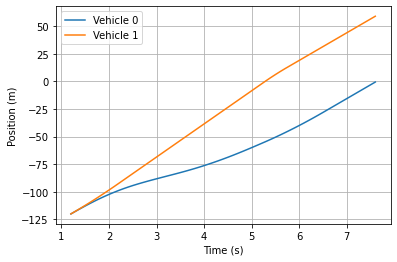

In [389]:
t_series = T*np.linspace(0,L-1,num=L)

for i in range(2):
    plt.plot(t_series[enter_t:exit_t], X_hist[i,0,:][enter_t:exit_t], label = "Vehicle " + str(i))
plt.grid()
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
# filename = 'plots/postion.png'
# plt.savefig(filename)
# filename = 'plots/position' +'.tex'
# tikzplotlib.save(filename)

In [390]:
d = np.zeros(L)
for i in range(L):
    p1 = X_hist[0,0,i]; p2 = X_hist[1,0,i]
    d[i] = distance(p1, p2, ang)

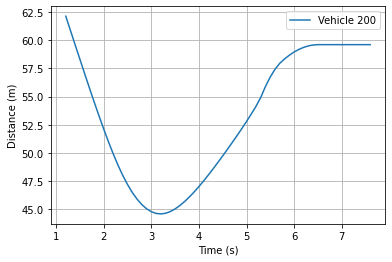

In [391]:
plt.plot(t_series[enter_t:exit_t], d[enter_t:exit_t], label = "Vehicle " + str(i))
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.legend(loc="upper right")
# filename = 'plots/distance.png'
# plt.savefig(filename)
# filename = 'plots/distance' +'.tex'
# tikzplotlib.save(filename)

Text(0, 0.5, 'Velocity (m)')

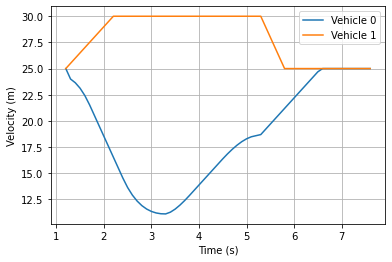

In [392]:
for i in range(2):
    plt.plot(t_series[enter_t:exit_t], X_hist[i,1,:][enter_t:exit_t], label = "Vehicle " + str(i))
plt.grid()
plt.legend(loc="upper right")
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m)')
# filename = 'plots/velocity.png'
# plt.savefig(filename)
# filename = 'plots/velocity' +'.tex'
# tikzplotlib.save(filename)